In [9]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as pl
from scipy.stats import ks_2samp
from scipy.optimize import minimize

import george
from george import kernels

In [2]:
data = np.random.randn(1000)
# x0 = np.random.randn(len(data))

def get_stats(x):
    return np.array((np.mean(x), np.log(np.var(x))))

data_stats = get_stats(data)

def get_theta_stats(theta):
    mu, ln_sig = theta
    x = mu + np.exp(ln_sig) * np.random.randn(len(data))
    return get_stats(x)

def get_distance(params):
    mu, ln_sig = params
    x = mu + np.exp(ln_sig) * np.random.randn(len(data))
    stats = get_stats(x)
    return np.sum((stats - data_stats) ** 2)

# def resample():
#     global x0
#     x0 = np.random.randn(len(data))
    
prior_mean = np.array([0.0, 0.0])
prior_std = np.array([1.0, 1.0])

def lnprior(theta):
    return -0.5 * np.sum(((theta - prior_mean) / prior_std)**2, axis=-1)

def from_prior(size=1):
    return prior_mean[None] + prior_std[None] * np.random.randn(size, len(prior_mean))

In [3]:
def lnlike(theta):
    mu, ln_sig = theta
    return -0.5 * np.sum((data - mu)**2)*np.exp(-2.*ln_sig) - len(data) * ln_sig

def lnprob(theta):
    return lnlike(theta) + lnprior(theta)

In [4]:
training_theta = from_prior(1000)
training_stats = np.array(list(map(get_theta_stats, training_theta)))
training_lnlike = -0.5*np.sum((training_stats - data_stats) ** 2, axis=1)

mask = training_lnlike > training_lnlike.max() - 10

training_theta = training_theta[mask]
training_stats = training_stats[mask]
training_lnlike = training_lnlike[mask]

In [5]:
gps = [None for _ in range(training_stats.shape[1])]

def get_gps(thetas, stats, verbose=False, optimize=True):
    # metric = np.cov(thetas, rowvar=0)
    metric = np.var(thetas, axis=0)
    
    new = len(gps) > 0

    for i in range(stats.shape[1]):
        y = stats[:, i]
        
        gp = gps[i]
        if gp is None:
            amp = np.var(y)
            sigma2 = 1e-8 * np.sqrt(np.median((y - np.median(y))**2))
            kernel = amp * kernels.Matern32Kernel(np.array(metric), ndim=thetas.shape[1])
            gp = george.GP(kernel,
                           white_noise=sigma2, fit_white_noise=True,
                           mean=np.mean(y), fit_mean=True)
        else:
            gp = gp[0]
        gp.compute(thetas)
        
        if optimize:
            bounds = gp.get_bounds()
            bounds[1] = (-8, None)
            result = minimize(gp.nll, gp.get_vector(), jac=gp.grad_nll, args=(y, ),
                              method="L-BFGS-B", bounds=bounds)
            gp.set_vector(result.x)
            if verbose:
                print(result)

        gps[i] = (gp, y, float(np.exp(gp.white_noise.get_vector())))
    
    return gps

In [6]:
gps = get_gps(training_theta, training_stats, verbose=True)

  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
     nfev: 92
      nit: 26
      jac: array([  2.74342974e-06,  -4.56633768e-03,  -2.94791535e-04,
         5.62795619e-04,   3.10156528e-05])
  success: False
   status: 2
        x: array([  1.18143569,  -5.30079499,  14.07785931,  17.25247858,  38.70223789])
      fun: -1173.6825216848438
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
     nfev: 54
      nit: 24
      jac: array([ -1.16125238e-06,  -1.11117414e-01,  -6.18014336e-02,
        -3.07003567e-05,   7.21587157e-02])
  success: True
   status: 0
        x: array([ -0.04020563,  -6.24672722,  15.71122709,  39.15419295,  17.5222904 ])
      fun: -1627.5854440127932


In [7]:
mus = [gp.sample_conditional(y, training_theta) for gp, y, _ in gps]

/Users/dfm/anaconda/lib/python3.4/site-packages/george-1.0.0.dev0-py3.4-macosx-10.5-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


/Users/dfm/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/dfm/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


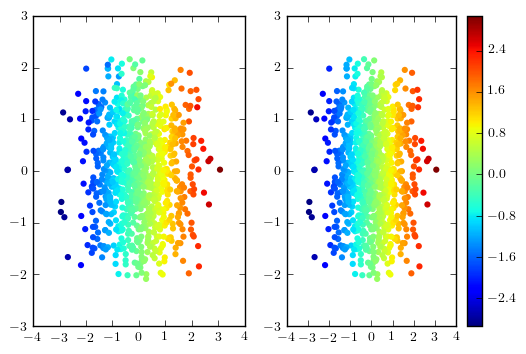

In [11]:
i = 0
y = training_stats[:, i]
vmin = y.min()
vmax = y.max()

fig, axes = pl.subplots(1, 2)
cf = axes[0].scatter(training_theta[:, 0], training_theta[:, 1], c=y, edgecolor="none", vmin=vmin, vmax=vmax)
axes[1].scatter(training_theta[:, 0], training_theta[:, 1], c=mus[i], edgecolor="none", vmin=vmin, vmax=vmax)
pl.colorbar(cf)

In [12]:
def gpsabc_mh_step(theta, error_tol, M=100, stepsize=0.1):
    global gps, training_theta, training_stats
    while True:
        theta_prime = theta + stepsize*np.random.randn(len(theta))
        alpha = lnprior(theta_prime) - lnprior(theta) + np.zeros(M)
        X = np.vstack((theta, theta_prime))
        for i, (gp, y, sigma2) in enumerate(gps):
            mu = gp.sample_conditional(y, X, size=M)
            norm = -0.5 * (mu - data_stats[i])**2 / sigma2
            alpha += np.diff(norm, axis=1)[:, 0]

        tau = np.median(alpha)

        u = np.log(np.random.rand(1000))
        p_minus = np.mean(alpha[None, :] <= u[:, None], axis=1)
        p_plus = 1.0 - p_minus
        error = np.mean((u <= tau) * p_minus + (u > tau) * p_plus)
        print(error)
        if error > error_tol:
            training_theta = np.concatenate((training_theta, theta_prime[None, :]), axis=0)
            training_stats = np.concatenate((training_stats, (get_theta_stats(theta_prime))[None, :]), axis=0)
            gps = get_gps(training_theta, training_stats, optimize=False)
        else:
            if np.log(np.random.rand()) < tau:
                return theta_prime
            return theta

In [32]:
chain = np.empty((1000, training_theta.shape[1]))
chain[0] = training_theta[np.argmax(training_lnlike)]
for i in range(1, len(chain)):
    chain[i] = gpsabc_mh_step(chain[i-1], 0.01, M=1000, stepsize=np.array([0.1, 0.05]))

0.053493
0.006769
0.0
0.002735
0.046105
0.005713
0.0
0.004581
0.039637
0.022599
0.006958
0.007287
0.037156
0.013132
0.004753
0.0
0.0
0.0
9e-06
0.0
0.027679
0.000892
0.001554
0.00011
0.000271
0.012643
0.007075
0.01757
0.01869
0.012641
0.013201
0.002164
0.0
0.001685
0.018371
0.004278
0.005873
0.007697
0.006258
0.023456
0.012773
0.00313
0.0
7.9e-05
0.002107
0.000461
0.0
0.000255
0.0
0.014394
0.003029
0.020842
0.0
0.0
0.016579
0.018844
0.019834
0.004185
0.019292
0.003925
0.00882
0.014571
0.009504
0.001461
0.010195
0.00122
0.011665
0.006185
0.0
0.016569
0.026994
3.9e-05
0.00043
0.00682
0.011709
0.001313
0.016243
0.0
0.014111
0.004986
0.011031
0.003484
0.004718
0.003607
0.002771
0.004756
0.000688
0.015743
0.004424
0.004611
0.001323
0.008448
0.02106
0.011427
0.025817
0.002776
0.012198
0.006393
0.001916
0.028142
0.0
0.003763
0.0
0.0
0.000249
0.00525
0.0
0.0
0.016949
0.0
0.004627
0.039462
0.003876
0.0
0.049709
0.023192
0.044471
0.0
0.014759
0.001115
0.0
0.017682
0.0
0.0
3e-06
0.0
0.008311
0.010

/Users/dfm/anaconda/lib/python3.4/site-packages/george-1.0.0.dev0-py3.4-macosx-10.5-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


(array([   2.,   14.,   31.,   70.,   86.,  370.,  346.,   41.,   35.,    5.]),
 array([-0.21199228, -0.17406   , -0.13612771, -0.09819542, -0.06026314,
        -0.02233085,  0.01560143,  0.05353372,  0.09146601,  0.12939829,
         0.16733058]),
 <a list of 10 Patch objects>)

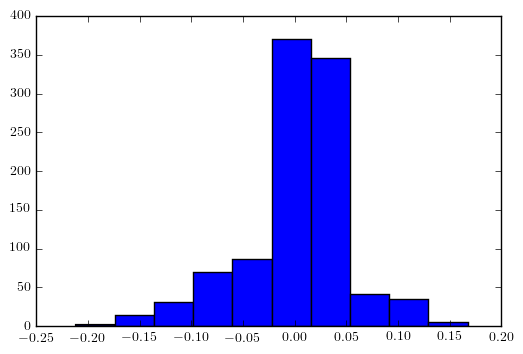

In [33]:
pl.hist(chain[:, 0])

In [34]:
gps = get_gps(training_theta, training_stats, verbose=True)

  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
     nfev: 27
      nit: 6
      jac: array([  2.74936690e-06,  -7.05461711e-02,   2.11643577e-02,
        -3.02718907e-02,   7.43488150e-05])
  success: True
   status: 0
        x: array([  1.18143522,  -5.6877685 ,  14.07754969,  17.25314666,  38.70223003])
      fun: -2271.9744412445416
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
     nfev: 74
      nit: 5
      jac: array([ -1.14127277e-06,   2.26654911e-02,  -5.37195206e-02,
        -3.83255429e-05,   6.81322803e-02])
  success: False
   status: 2
        x: array([ -0.04020551,  -6.26100152,  15.71562948,  39.15419678,  17.51538784])
      fun: -2729.3722654358071


In [35]:
mus = [gp.sample_conditional(y, training_theta) for gp, y, _ in gps]

/Users/dfm/anaconda/lib/python3.4/site-packages/george-1.0.0.dev0-py3.4-macosx-10.5-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


In [36]:
len(training_theta)

1610

/Users/dfm/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


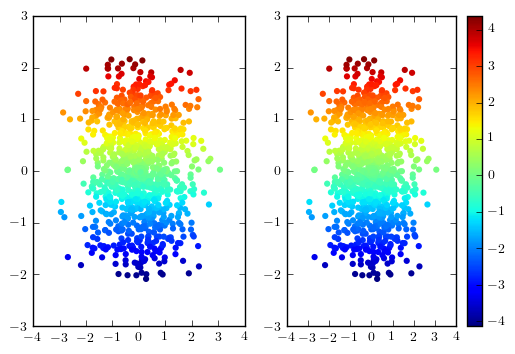

In [37]:
i = 1
y = training_stats[:, i]
vmin = y.min()
vmax = y.max()

fig, axes = pl.subplots(1, 2)
cf = axes[0].scatter(training_theta[:, 0], training_theta[:, 1], c=y, edgecolor="none", vmin=vmin, vmax=vmax)
axes[1].scatter(training_theta[:, 0], training_theta[:, 1], c=mus[i], edgecolor="none", vmin=vmin, vmax=vmax)
pl.colorbar(cf)

In [38]:
ndim, nwalkers = 2, 36
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

p0 = from_prior(nwalkers)
pos, _, _ = sampler.run_mcmc(p0, 300);
sampler.reset()
pos, _, _ = sampler.run_mcmc(pos, 1000);

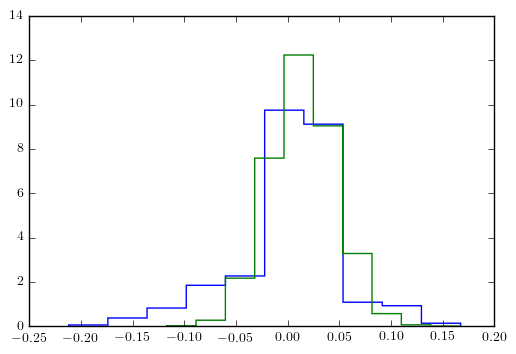

In [40]:
i = 0
pl.hist(chain[:, i], histtype="step", normed=True)
pl.hist(sampler.flatchain[:, i], histtype="step", normed=True);